In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pylab import mpl
import seaborn as sns
import numpy as np

In [2]:
from matplotlib.font_manager import FontProperties

# 设置字体
font_path = '../SimHei.ttf'  # 替换为你的字体文件路径
font = FontProperties(fname=font_path, size=16)

In [3]:
filepath = 'probability_info.xlsx'
df = pd.read_excel(filepath)
df.drop(columns=['城市','订单日期'],inplace=True)
print(df)

            制造商 产品名称 产品描述    类别 子类别  地区 省/自治区    细分    折扣  数量           单价  \
0      Kleencut   剪刀    钢  办公用品  用品  华北    河北   消费者  0.00   3    99.191047   
1      Stiletto   剪刀    钢  办公用品  用品  华北    河北   消费者  0.00   3   106.528319   
2          Acme   剪刀  锯齿状  办公用品  用品  华东    山东    公司  0.40   5   117.379087   
3      Stiletto   剪刀  锯齿状  办公用品  用品  华北    河北    公司  0.00   1   106.528319   
4      Kleencut   剪刀   工业  办公用品  用品  中南    广西    公司  0.40   3    99.191047   
...         ...  ...  ...   ...  ..  ..   ...   ...   ...  ..          ...   
11748     Bevis   木桌   黑色    家具  桌子  西南    四川   消费者  0.60   1  2492.574074   
11749     Lesro   木桌   组装    家具  桌子  中南    广东    公司  0.25   3  2190.238889   
11750     Lesro   木桌   白色    家具  桌子  中南    广东  小型企业  0.25   5  2190.238889   
11751     Lesro   木桌   白色    家具  桌子  中南    湖北    公司  0.60   2  2190.238889   
11752     Bevis  电脑桌   黑色    家具  桌子  华北    天津    公司  0.25  13  2307.794872   

       是否购买  
0         0  
1         0  
2         0  
3      

## 数据处理

### 相关性分析

In [4]:
correlation_matrix = df[['数量','折扣','单价','是否购买']].corr()
print(correlation_matrix)

            数量        折扣        单价      是否购买
数量    1.000000 -0.003289 -0.010333  0.004209
折扣   -0.003289  1.000000  0.116234  0.027149
单价   -0.010333  0.116234  1.000000  0.023720
是否购买  0.004209  0.027149  0.023720  1.000000


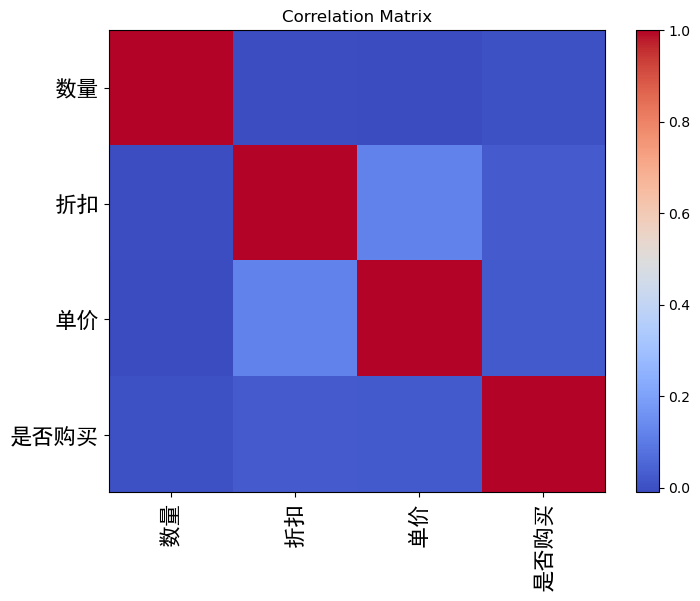

In [5]:
# 绘制相关性矩阵热图
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90,fontproperties=font)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns,fontproperties=font)
plt.title('Correlation Matrix')
plt.show()

### SMOTENC

In [6]:
print(df.columns)

Index(['制造商', '产品名称', '产品描述', '类别', '子类别', '地区', '省/自治区', '细分', '折扣', '数量',
       '单价', '是否购买'],
      dtype='object')


In [7]:
X = df.drop(columns=['是否购买'])
y = df['是否购买']

In [8]:
from collections import Counter

print("SMOTENC前的类别分布:", Counter(y))

SMOTENC前的类别分布: Counter({1: 9935, 0: 1818})


In [9]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5,6,7], random_state=42)
X, y = smote_nc.fit_resample(X, y)

In [10]:
from collections import Counter

print("SMOTENC后的类别分布:", Counter(y))

SMOTENC后的类别分布: Counter({0: 9935, 1: 9935})


### 独热编码

In [11]:
X = pd.get_dummies(X, columns=['制造商', '产品名称', '产品描述', '类别', '子类别', '地区', '省/自治区', '细分'], prefix=['制造商', '产品名称', '产品描述', '类别', '子类别', '地区', '省/自治区', '细分'])
print(X.shape)

(19870, 267)


## 数据拆分

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42,stratify=y_temp)

print("训练集大小:", X_train.shape[0])
print("验证集大小:", X_val.shape[0])
print("测试集大小:", X_test.shape[0])

训练集大小: 13909
验证集大小: 1967
测试集大小: 3994


### 标准化

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 模型训练

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

In [15]:
models = []
auc_list = []
acc_list = []
f1_list=[]
recall_list=[]
precision_list=[]

### 随机森林

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# 定义随机森林分类器
classifier = RandomForestClassifier(random_state=42, criterion = 'entropy', oob_score=True)

from sklearn.metrics import make_scorer
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer (recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
# 定义超参数的范围
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

from sklearn.model_selection import StratifiedKFold
refit_score='precision_score'
skf = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(classifier, param_grid, refit=refit_score, cv=skf,
return_train_score=True, scoring=scorers, n_jobs=-1) 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(criterion='entropy',
                                              oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='precision_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [18]:
importances=grid_search.best_estimator_.feature_importances_

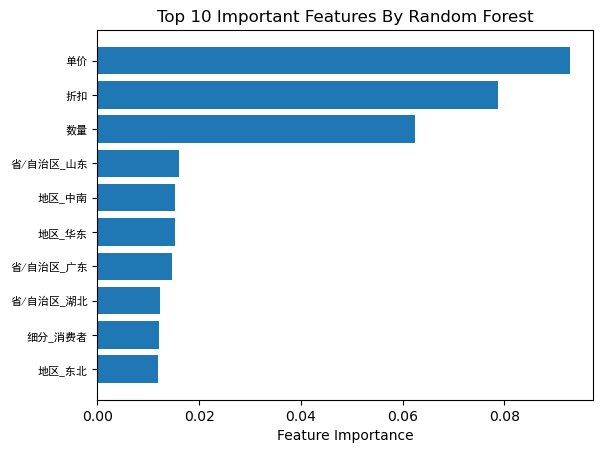

In [31]:
top10_indices = np.argsort(importances)[-10:]
feature_names = X.columns.tolist()
# 获取前20个最重要的特征名称
top10_feature_names = [feature_names[idx] for idx in top10_indices]

# 绘制条状图
plt.barh(range(10), importances[top10_indices], align='center')
plt.yticks(range(10), top10_feature_names, fontproperties=FontProperties(fname=font_path, size=8))
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features By Random Forest')
plt.show()

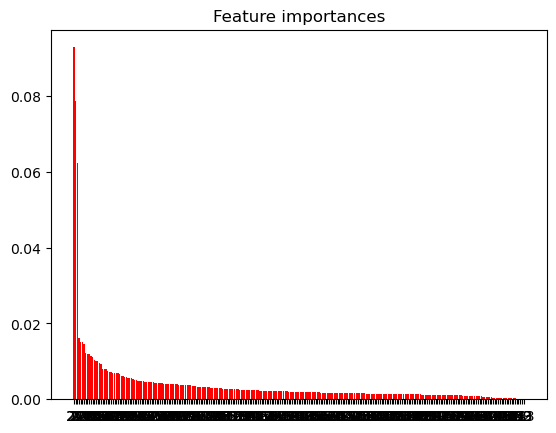

In [20]:

indices=np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),importances[indices],color='r',align='center')
plt.xticks(range(X_train.shape[1]),indices)
plt.show()

In [18]:
# 输出最佳超参数
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 计算性能指标
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# 输出性能指标
print("AUC:", auc)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

models.append("Random Forest")
auc_list.append(auc)
acc_list.append(acc)
f1_list.append(f1)
recall_list.append(recall)
precision_list.append(precision)

AUC: 0.936853703188734
Accuracy: 0.8733099649474211
F1 Score: 0.8748763600395647
Recall: 0.885828743114672
Precision: 0.8641914997557401


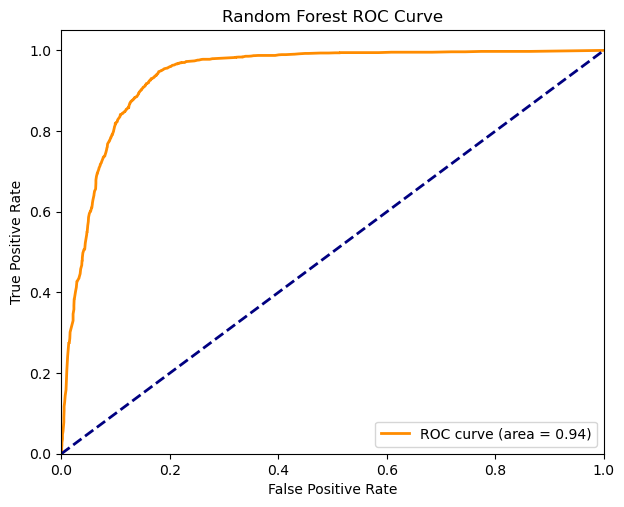

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thre = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

drawRoc(roc_auc, fpr, tpr)


### 逻辑回归

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
# 定义逻辑回归分类器
logreg = LogisticRegression()

# 定义要搜索的超参数网格
param_grid = {
    'penalty': ['l1', 'l2'],  # 正则化类型
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # 正则化强度的倒数
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [24]:
y_pred = grid_search.predict(X_test)
# 输出最佳超参数
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 1, 'penalty': 'l2'}


In [25]:
# 获取最佳模型
best_model = grid_search.best_estimator_

# 预测测试集
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 计算指标
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# 打印结果
print("Best Parameters:", grid_search.best_params_)
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Best Parameters: {'C': 1, 'penalty': 'l2'}
AUC: 0.7240
Accuracy: 0.6630
F1 Score: 0.6475
Recall: 0.6189
Precision: 0.6787


In [26]:
models.append("Logistic Regression")
auc_list.append(auc)
acc_list.append(acc)
f1_list.append(f1)
recall_list.append(recall)
precision_list.append(precision)

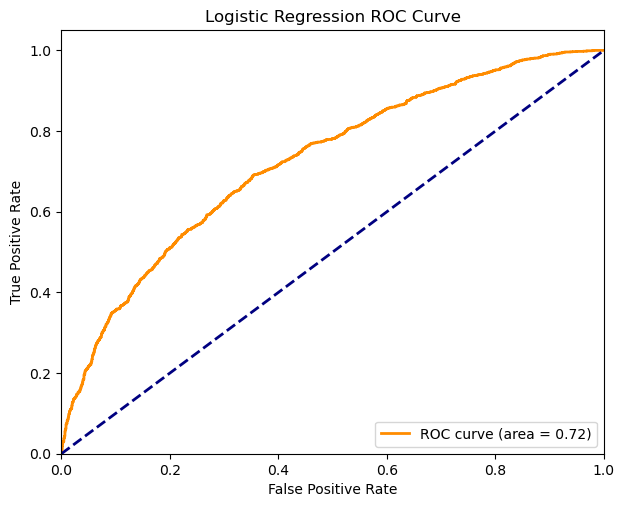

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thre = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic Regression ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

drawRoc(roc_auc, fpr, tpr)

### 贝叶斯

In [28]:
from sklearn.naive_bayes import GaussianNB

# 定义多项式朴素贝叶斯分类器
nb_classifier = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='roc_auc')

In [29]:
# 输出最佳超参数
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'var_smoothing': 1e-09}


In [30]:
# 获取最佳模型
best_model = grid_search.best_estimator_

# 预测测试集
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 计算指标
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# 打印结果
print("Best Parameters:", grid_search.best_params_)
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

Best Parameters: {'var_smoothing': 1e-09}
AUC: 0.6689
Accuracy: 0.5646
F1 Score: 0.2928
Recall: 0.1803
Precision: 0.7792


In [31]:
models.append("GaussianNB")
auc_list.append(auc)
acc_list.append(acc)
f1_list.append(f1)
recall_list.append(recall)
precision_list.append(precision)

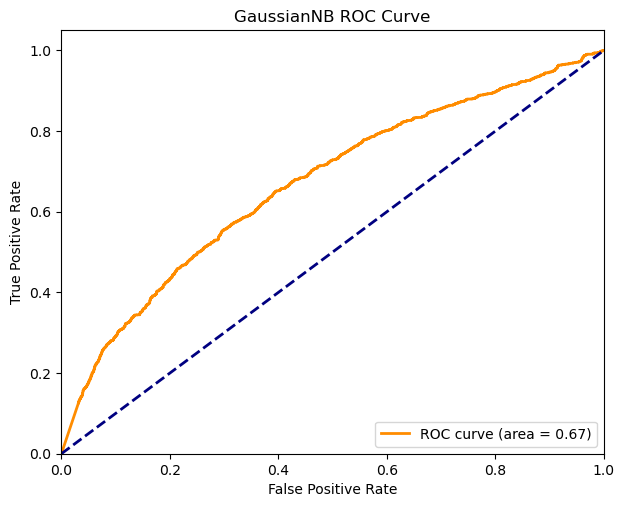

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thre = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('GaussianNB ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

drawRoc(roc_auc, fpr, tpr)

### AdaBoost

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 创建决策树弱分类器
base_classifier = DecisionTreeClassifier(max_depth=1)
# 创建AdaBoost分类器
adaboost_model = AdaBoostClassifier(base_classifier, random_state=42)

# 定义待搜索的参数范围
param_grid = {
    'n_estimators': [50, 100, 150],  # 弱分类器的数量
    'learning_rate': [0.1, 0.5, 1.0],  # 每个弱分类器的权重缩放因子
}

# 使用GridSearchCV进行参数搜索
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          random_state=42),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [34]:
# 输出最佳参数
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'learning_rate': 1.0, 'n_estimators': 150}


In [35]:
# 获取最佳模型
best_model = grid_search.best_estimator_

# 预测测试集
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 计算指标
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# 打印结果
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

AUC: 0.7846
Accuracy: 0.7061
F1 Score: 0.7097
Recall: 0.7186
Precision: 0.7010


In [36]:
models.append("AdaBoost")
auc_list.append(auc)
acc_list.append(acc)
f1_list.append(f1)
recall_list.append(recall)
precision_list.append(precision)

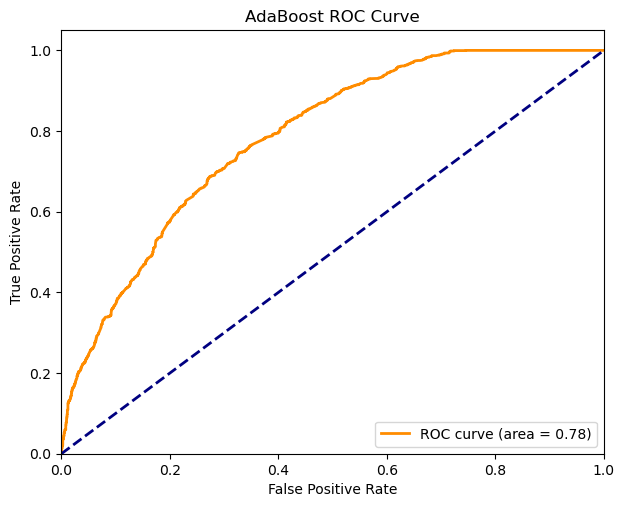

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thre = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AdaBoost ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

drawRoc(roc_auc, fpr, tpr)

### KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# 定义KNN模型
knn = KNeighborsClassifier()

# 定义要调整的参数及其候选值
param_grid = {
    'n_neighbors': [3, 5, 7, 9],          # K的取值
    'weights': ['uniform', 'distance'],  # 权重函数的取值
    'p': [1, 2]                           # 距离度量的指数
}

# 使用GridSearchCV进行网格搜索
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [39]:
# 输出最佳参数
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [40]:
# 获取最佳模型
best_model = grid_search.best_estimator_

# 预测测试集
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 计算指标
auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# 打印结果
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

AUC: 0.8734
Accuracy: 0.8140
F1 Score: 0.7967
Recall: 0.7291
Precision: 0.8782


In [41]:
models.append("KNN")
auc_list.append(auc)
acc_list.append(acc)
f1_list.append(f1)
recall_list.append(recall)
precision_list.append(precision)

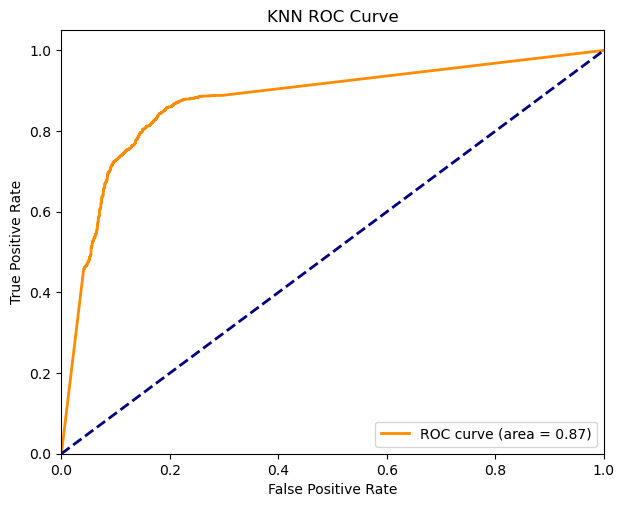

In [42]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thre = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

drawRoc(roc_auc, fpr, tpr)

## 模型评价

In [43]:
# 假设给定的数据
data = {
    'Model': models,
    'AUC': auc_list,
    'Accuracy': acc_list,
    'F1 Score': f1_list,
    'Recall': recall_list,
    'Precision': precision_list
}

# 创建DataFrame
df = pd.DataFrame(data)
print(df)

df = df.set_index('Model')

                 Model       AUC  Accuracy  F1 Score    Recall  Precision
0        Random Forest  0.936854  0.873310  0.874876  0.885829   0.864191
1  Logistic Regression  0.724030  0.662994  0.647459  0.618928   0.678748
2           GaussianNB  0.668930  0.564597  0.292802  0.180270   0.779221
3             AdaBoost  0.784606  0.706059  0.709693  0.718578   0.701026
4                  KNN  0.873433  0.813971  0.796717  0.729094   0.878166


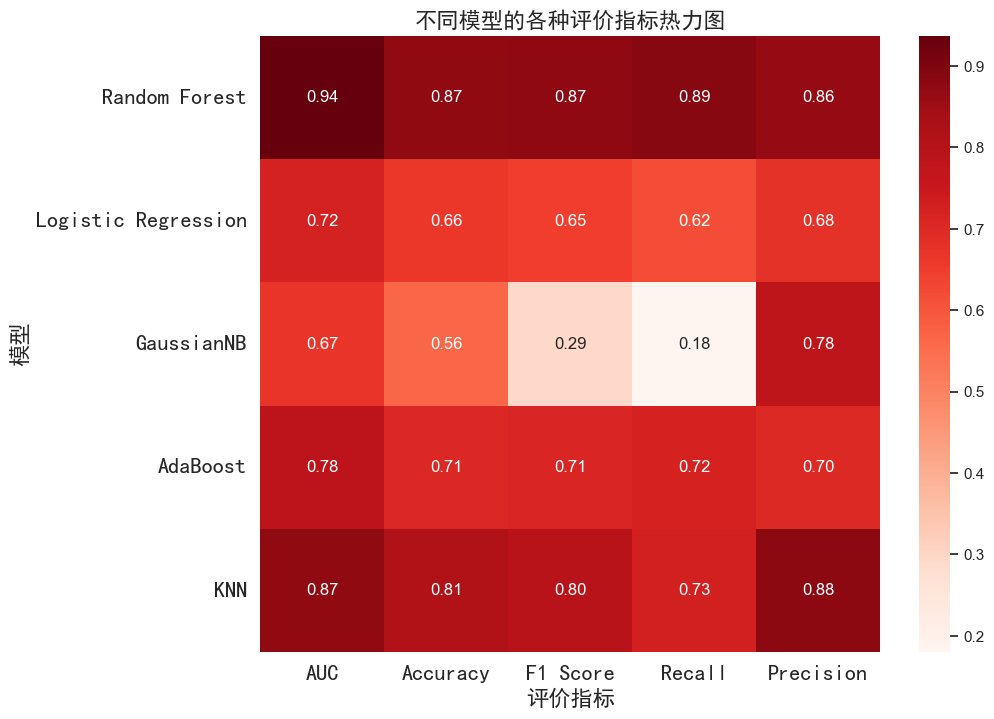

In [52]:
# 设置图形样式
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# 创建热力图
sns.heatmap(df,cmap='Reds', annot=True, fmt=".2f")
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font)
ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font, rotation=0)

# 设置图形标题和轴标签
plt.title('不同模型的各种评价指标热力图', fontproperties=font)
plt.xlabel('评价指标', fontproperties=font)
plt.ylabel('模型', fontproperties=font)

# 显示图形
plt.show()